# Network Simulation Evaluation

First import all needed libraries and set global constants and configurations:

In [1]:
import glob
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cm = 1/2.54
linewidth = 14.6979 * cm # line width in TuDa template
sns.set_theme(context='paper', style='whitegrid', palette='deep', rc={'figure.figsize':(linewidth, 10*cm)})

We define two functions to read in the `clab` output:

- `get_pidstat_df` reads in pidstat output and adds a duration column as well as a node column to identify the reading
- `get_network_df` reads in network traffic logs and adds a duration column as well as a node column to identify the reading. Also, some units are transformed to make the stats more readable

In [2]:
correct_log_header = "Time          UID       PID    %usr %system  %guest   %wait    %CPU   CPU  minflt/s  majflt/s     VSZ     RSS   %MEM   kB_rd/s   kB_wr/s kB_ccwr/s iodelay  Command\n"
del_col = ["Command", "PID", "%system","%guest", "%wait"]

def get_pidstat_df(scen_dir, nodes):
    pidstat_df = pd.DataFrame()
    
    for node_name in nodes:
        for filepath in glob.glob(f"net-sim/eval/{scen_dir}/results-*/n*/pidstat-{node_name}.csv.log"):

            # change header since Pandas will not be able to parse it correctly
            with open(filepath, "r") as fh:
                lines = fh.readlines()
            lines[0] = correct_log_header
            # store it in a temporary file object so we don't need to
            # modify the (potentially protected) original file
            data = io.StringIO("".join(lines))

            df = pd.read_fwf(data)
            df["duration"] = df["Time"] - df["Time"][0]
            df["node"] = node_name
            # for c in del_col:
            #        del df[c]
            pidstat_df = pd.concat([pidstat_df, df], ignore_index=True)
            
    return pidstat_df

In [3]:
csv_header = ["timestamp", "iface_name", "bytes_out/s", "bytes_in/s", "bytes_total/s", "bytes_in", "bytes_out", "packets_out/s",
    "packets_in/s", "packets_total/s", "packets_in", "packets_out", "errors_out/s", "errors_in/s", "errors_in", "errors_out"]

def get_network_df(scen_dir, nodes):
    net_df = pd.DataFrame()
    
    for node_name in nodes:
        for filepath in glob.glob(f"net-sim/eval/{scen_dir}/results-*/n*/net-{node_name}.log"):
            df = pd.read_csv(filepath, sep=";", names=csv_header)
            df["duration"] = (df["timestamp"] - df["timestamp"][0]).round(0).astype(int)
            df["node"] = node_name
            df["kb_in/s"] = df["bytes_in/s"] / 1000
            df["kb_out/s"] = df["bytes_out/s"] / 1000
            df["kb_total/s"] = df["bytes_total/s"] / 1000
            
            net_df = pd.concat([net_df, df], ignore_index=True)
    
    return net_df

### Scenario `1k`

In this scenario, three nodes start off with no connection between them. `n1` is pre-loaded with $1000$ articles that are in the DB of the *moNNT.py Server* and in the store of the *dtnd*.

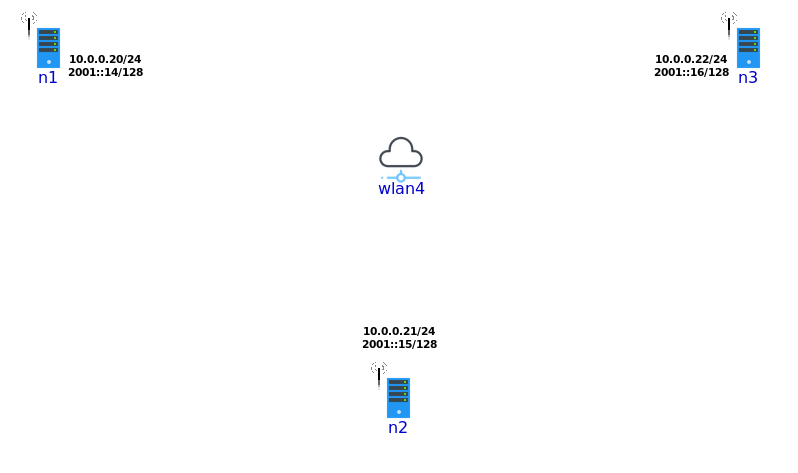

Then the simulation runs through the following steps:

1. Wait 10 seconds
2. `n2` moves into proximity of `n1` -- after a short period both *dtnd* instances will discover eachother and exchange previously unknown bundles, which will then be pushed to the respective *moNNT.py* instance.
3. Wait 10 seconds
4. `n2` moves into proximity of `n3` -- analog to step 2.
5. Wait 10 seconds

In [4]:
nodes_1k = ["n1", "n2", "n3"]
scen_dir_1k = "1k"

#### CPU utilization, memory usage, and storage writes

In [5]:
pidstat_1k_df = get_pidstat_df(scen_dir=scen_dir_1k, nodes=nodes_1k)

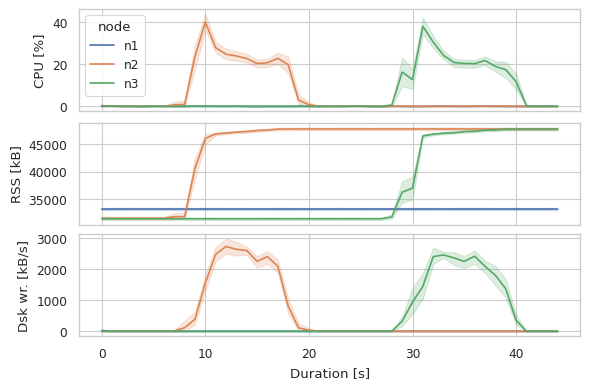

In [6]:
stats_1k = ["%CPU", "RSS", "kB_wr/s"]
cols_1k, rows_1k = [1, len(stats_1k)]

fig_1k, ax_1k = plt.subplots(rows_1k, cols_1k, figsize=(linewidth, rows_1k*3.2*cm), constrained_layout=True, sharex=True)
for i, g in enumerate(stats_1k):
    sns.lineplot(data=pidstat_1k_df, x="duration", y=g, hue="node", ax=ax_1k[i])
    if i > 0:
        ax_1k[i].get_legend().remove()

# Update labels
ax_1k[0].set(ylabel="CPU [%]")  # , title="Scenario 1k Performance Metrics")
ax_1k[1].set(ylabel="RSS [kB]")
ax_1k[2].set(ylabel="Dsk wr. [kB/s]", xlabel="Duration [s]")

# save legend for later on
global_handles, global_labels = ax_1k[0].get_legend_handles_labels()

In [7]:
fig_1k.savefig("ch6_1k_cpu_str.pdf")

#### Network transfers

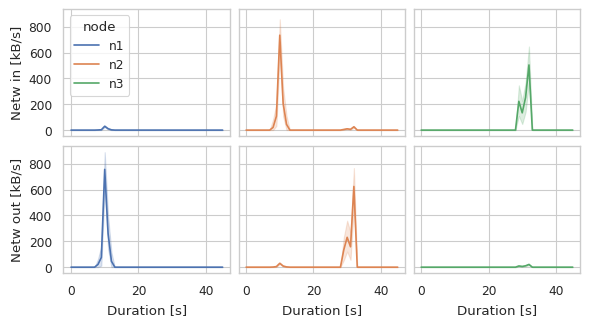

In [8]:
net_1k_df = get_network_df(scen_dir=scen_dir_1k, nodes=nodes_1k)
y_cols_1k = ["kb_in/s", "kb_out/s"]  # , "bytes_total/s"]

fig_net_1k, ax_net_1k = plt.subplots(2, 3, figsize=(linewidth, 2*4*cm), constrained_layout=True, sharey=True, sharex=True)
for i, y_col in enumerate(y_cols_1k):
    for j, n in enumerate(nodes_1k):
        sns.lineplot(
            data=net_1k_df[(net_1k_df["iface_name"] == "total") & (net_1k_df["node"] == n)],
            x="duration", y=y_col, color=sns.color_palette()[j], ax=ax_net_1k[i][j])

# Update Labels
# _ = g.set(xlabel='Article Batch Size', ylabel='Rate [articles / sec]', title="Rate of article ingestion")
ax_net_1k[0][0].set(ylabel="Netw in [kB/s]")
ax_net_1k[1][0].set(ylabel="Netw out [kB/s]", xlabel="Duration [s]")
ax_net_1k[1][1].set(xlabel="Duration [s]")
ax_net_1k[1][2].set(xlabel="Duration [s]")
_ = ax_net_1k[0][0].legend(title="node", handles=global_handles, labels=global_labels, loc='upper left')

In [9]:
fig_net_1k.savefig("ch6_1k_net.pdf")

#### Reliability

In order to call the implementation **reliable**, all messages that were first stored on `n1` must be transferred
to `n3` through `n2`. We will count received bundles on nodes `n2` and `n3` to ensure reliable transfer.

The following code searches all produced `dtnd` logs on nodes `n2` and `n3` for the phrase `Received new bundle: dtn://n1`, which should occur
exactly $1000$ times on each node on each run. In this case, the code will output `True`:

In [10]:
counts_1k = []
for node_name in nodes_1k[1:]:
    for filepath in glob.glob(f"net-sim/eval/1k/results-*/n*/nohup.dtnd_{node_name}.log"):
        with open(filepath, "r") as fh:
            counts_1k.append(fh.read().count("Received new bundle: dtn://n1"))
all([c == 1000 for c in counts_1k])

True

### Scenario `always_on`

In this scenario, two nodes are within range of each other continuously. After an initial delay of 2 seconds, news clients on both nodes send articles every 0.3 seconds. These are first processed by the local *moNNT.py* and *dtnd* instances before being sent to the other node, where they are also processed and integrated into the database, respectively store.

In [11]:
nodes_ao = ["n1", "n2"]
scen_dir_ao = "always_on"

#### CPU utilization, memory usage, and storage writes

In [12]:
pidstat_ao_df = get_pidstat_df(scen_dir=scen_dir_ao, nodes=nodes_ao)

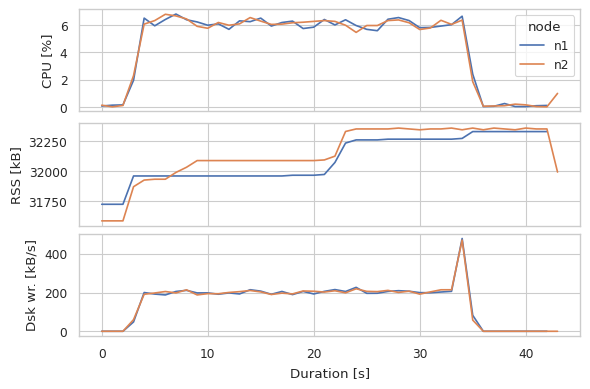

In [13]:
stats_ao = ["%CPU", "RSS", "kB_wr/s"]
cols_ao, rows_ao = [1, len(stats_ao)]

fig_ao, ax_ao = plt.subplots(rows_ao, cols_ao, figsize=(linewidth, rows_ao*3.2*cm), constrained_layout=True, sharex=True)
for i, g in enumerate(stats_ao):
    sns.lineplot(data=pidstat_ao_df, x="duration", y=g, hue="node", ax=ax_ao[i], errorbar=None)
    if i > 0:
        ax_ao[i].get_legend().remove()

# Update labels
ax_ao[0].set(ylabel="CPU [%]")  # , title="Scenario 1k Performance Metrics")
ax_ao[1].set(ylabel="RSS [kB]")
ax_ao[2].set(ylabel="Dsk wr. [kB/s]", xlabel="Duration [s]")
        
# save legend for later on
global_handles, global_labels = ax_ao[0].get_legend_handles_labels()

In [14]:
fig_ao.savefig("ch6_always_on_cpu_str.pdf")

#### Network transfers

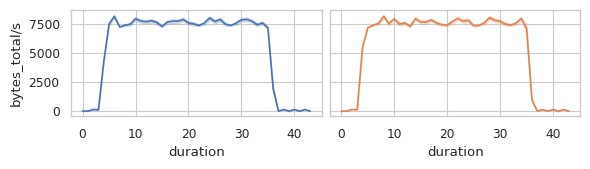

In [15]:
net_ao_df = get_network_df(scen_dir=scen_dir_ao, nodes=nodes_ao)
# y_cols = ["kb_in/s", "kb_out/s"]  # , 
y_cols_net_ao = "bytes_total/s"

fig_net_ao, ax_net_ao = plt.subplots(1, len(nodes_ao), figsize=(linewidth, 4*cm), constrained_layout=True, sharey=True, sharex=True)
for i, n in enumerate(nodes_ao):
    sns.lineplot(
        data=net_ao_df[(net_ao_df["iface_name"] == "total") & (net_ao_df["node"] == n)],
        x="duration", y=y_cols_net_ao, color=sns.color_palette()[i], ax=ax_net_ao[i])
global_handles, global_labels = ax_ao[0].get_legend_handles_labels()

In [16]:
fig_net_ao.savefig("ch6_always_on_net.pdf")

### Scenario `busynode`

In [17]:
nodes_bn = ["n1", "n2"]
scen_dir_bn_nozip = "busynode_nozip"
scen_dir_bn_zip = "busynode_zip"
pidstat_bn_nozip_df = get_pidstat_df(scen_dir=scen_dir_bn_nozip, nodes=nodes_bn)
pidstat_bn_zip_df = get_pidstat_df(scen_dir=scen_dir_bn_zip, nodes=nodes_bn)

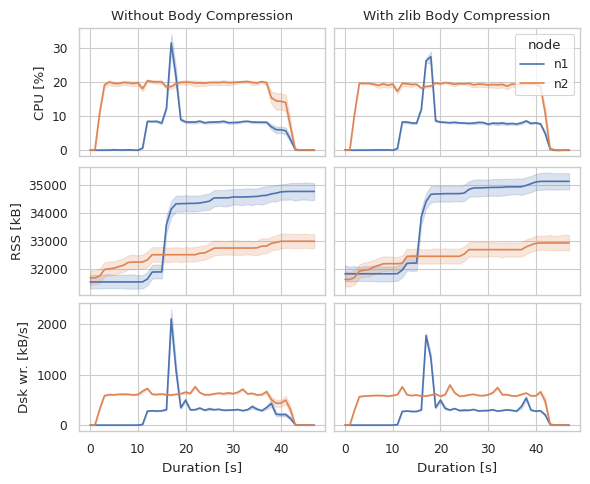

In [18]:
cols_bn, rows_bn = [2, 3]

fig_bn, ax_bn = plt.subplots(rows_bn, cols_bn, figsize=(linewidth, rows_bn*4*cm), constrained_layout=True, sharex=True, sharey="row")
for i, g in enumerate(["%CPU", "RSS", "kB_wr/s"]):
    sns.lineplot(data=pidstat_bn_nozip_df, x="duration", y=g, hue="node", ax=ax_bn[i][0], legend=False)
    sns.lineplot(data=pidstat_bn_zip_df, x="duration", y=g, hue="node", ax=ax_bn[i][1])
    if i > 0:
        ax_bn[i][1].get_legend().remove()

# Update labels
_ = ax_bn[0][0].set(ylabel="CPU [%]", title="Without Body Compression")
_ = ax_bn[0][1].set(title="With zlib Body Compression")
_ = ax_bn[1][0].set(ylabel="RSS [kB]")
_ = ax_bn[2][0].set(ylabel="Dsk wr. [kB/s]", xlabel="Duration [s]")
_ = ax_bn[2][1].set(xlabel="Duration [s]")

In [19]:
fig_bn.savefig("ch6_busynode_cpu_str.pdf")

#### Network transfers

In [20]:
net_bn_nozip_df = get_network_df(scen_dir=scen_dir_bn_nozip, nodes=nodes_bn)
net_bn_nozip_df = net_bn_nozip_df[(net_bn_nozip_df["iface_name"] == "total")]

net_bn_zip_df = get_network_df(scen_dir=scen_dir_bn_zip, nodes=nodes_bn)
net_bn_zip_df = net_bn_zip_df[(net_bn_zip_df["iface_name"] == "total")]
y_cols_net_bn = ["kb_in/s", "kb_out/s"]  # , "bytes_total/s"]
"""
fig_net_bn, ax_net_bn = plt.subplots(len(y_cols_net_bn), len(nodes_bn), figsize=(3*linewidth, 2*2*4*cm), constrained_layout=True, sharey=True, sharex=True)
for in_out, y_col in enumerate(y_cols_net_bn):
    for j, n in enumerate(nodes_bn):
        sns.lineplot(data=net_bn_nozip_df[net_bn_nozip_df["node"] == n], x="duration", y=y_col, ax=ax_net_bn[in_out][j], errorbar=None)
        sns.lineplot(data=net_bn_zip_df[net_bn_zip_df["node"] == n], x="duration", y=y_col, ax=ax_net_bn[in_out][j], errorbar=None)

# _ = ax_net_bn[0][0].legend(current_handles, ["node", "n1", "n2", "n3"], loc="upper left")
"""

'\nfig_net_bn, ax_net_bn = plt.subplots(len(y_cols_net_bn), len(nodes_bn), figsize=(3*linewidth, 2*2*4*cm), constrained_layout=True, sharey=True, sharex=True)\nfor in_out, y_col in enumerate(y_cols_net_bn):\n    for j, n in enumerate(nodes_bn):\n        sns.lineplot(data=net_bn_nozip_df[net_bn_nozip_df["node"] == n], x="duration", y=y_col, ax=ax_net_bn[in_out][j], errorbar=None)\n        sns.lineplot(data=net_bn_zip_df[net_bn_zip_df["node"] == n], x="duration", y=y_col, ax=ax_net_bn[in_out][j], errorbar=None)\n\n# _ = ax_net_bn[0][0].legend(current_handles, ["node", "n1", "n2", "n3"], loc="upper left")\n'

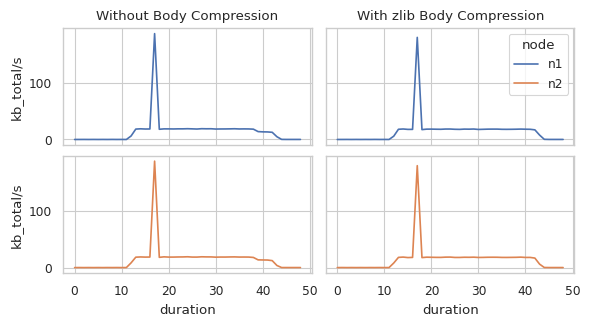

In [21]:
fig_net_bn, ax_net_bn = plt.subplots(2, 2, figsize=(linewidth, 2*4*cm), constrained_layout=True, sharey=True, sharex=True)
sns.lineplot(data=net_bn_nozip_df[net_bn_nozip_df["node"] == "n1"], x="duration", y="kb_total/s", color=sns.color_palette()[0], ax=ax_net_bn[0][0], errorbar=None)
sns.lineplot(data=net_bn_zip_df[net_bn_zip_df["node"] == "n1"], x="duration", y="kb_total/s", color=sns.color_palette()[0], ax=ax_net_bn[0][1], errorbar=None)
sns.lineplot(data=net_bn_nozip_df[net_bn_nozip_df["node"] == "n2"], x="duration", y="kb_total/s", color=sns.color_palette()[1], ax=ax_net_bn[1][0], errorbar=None)
sns.lineplot(data=net_bn_zip_df[net_bn_zip_df["node"] == "n2"], x="duration", y="kb_total/s", color=sns.color_palette()[1], ax=ax_net_bn[1][1], errorbar=None)

ax_net_bn[0][0].set(title="Without Body Compression")
ax_net_bn[0][1].set(title="With zlib Body Compression")
_ = ax_net_bn[0][1].legend(title="node", handles=global_handles, labels=global_labels, loc='upper right')

In [22]:
net_bn_nozip_df["packets_in"].sum()

57599

In [23]:
net_bn_zip_df["packets_in"].sum()

57804

In [24]:
net_bn_nozip_df.columns

Index(['timestamp', 'iface_name', 'bytes_out/s', 'bytes_in/s', 'bytes_total/s',
       'bytes_in', 'bytes_out', 'packets_out/s', 'packets_in/s',
       'packets_total/s', 'packets_in', 'packets_out', 'errors_out/s',
       'errors_in/s', 'errors_in', 'errors_out', 'duration', 'node', 'kb_in/s',
       'kb_out/s', 'kb_total/s'],
      dtype='object')